### PyTorch implementation of the RIM paper (Recurrent Independent Mechanism)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import math 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from rim import RIMNetwork,RIMNetwork_specialized,RIMNetwork_specialized_multHead,RIMNetwork_multHead

def compress_labels(labels):
    new_labels = np.zeros_like(labels)
    for i in range(labels.shape[0]):
        prev_val = 0
        for j in range(labels.shape[1]):
            curr_val = labels[i,j]
            if curr_val != 0 and curr_val == prev_val:
                new_labels[i,j] = 0
            else:
                new_labels[i,j] = curr_val
                if j+1 < labels.shape[1]:
                    new_labels[i,j+1] = 1 # oopas???
            prev_val = curr_val
    return new_labels


def compress_labels(labels):
    new_labels = np.zeros_like(labels)
    for i in range(labels.shape[0]):
        prev_val = 0
        repeat_count = 0
        for j in range(labels.shape[1]):
            curr_val = labels[i,j]
            if curr_val != 0 and curr_val == prev_val:
                repeat_count += 1
                if repeat_count >= 2:  # After two occurrences, start zeroing out
                    new_labels[i,j] = 0
                else:
                    new_labels[i,j] = curr_val
            else:
                new_labels[i,j] = curr_val
                repeat_count = 0
            prev_val = curr_val
    return new_labels

### Multitask training

In [2]:
from torch.utils.data import Dataset, DataLoader
import matplotlib.font_manager
from neurogym import Dataset
from Mod_Cog.mod_cog_tasks import *
from matplotlib import rcParams
rcParams['font.sans-serif'] = "ubuntu"
rcParams['font.family'] = "ubuntu"

/home/felix/Documents/phd/.venv/lib/python3.11/site-packages/gym/envs/registration.py:396: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.
  logger.warn(


In [3]:
'''envs_simple = [go(), rtgo(), dlygo(), anti(), rtanti(), dlyanti(),
                dm1(), dm2(), ctxdm1(), ctxdm2(), multidm(), 
                dlydm1(), dlydm2(), ctxdlydm1(), ctxdlydm2(), multidlydm(), ]'''

              #   dms(), dnms(), dmc(), dnmc()]

envs_simple = [go(), rtgo(), dlygo(), anti(), rtanti(), dlyanti()]

schedule = RandomSchedule(len(envs_simple))

env = ScheduleEnvs(envs_simple, schedule=schedule, env_input=True)

# iterable dataset from which it is possible to draw samples
dataset = Dataset(env, batch_size=64, seq_len=100)
ob_size = env.observation_space.shape[0]
act_size = env.action_space.n

print('obs size', ob_size, 'act_size', act_size)

# To draw samples, use neurogym's dataset class:
inputs, labels = dataset()
print('inputs', inputs.shape, 'labels', labels.shape)

obs size 39 act_size 17
inputs (100, 64, 39) labels (100, 64)


In [4]:
batch_size = 64
hidden_size = 64
learning_rate = 0.001
num_epochs = 50

input_size = ob_size
output_size = act_size

num_mechanisms = 3
key_size = 2
rank = 2
num_heads = 1


model = RIMNetwork_multHead(input_size, hidden_size, output_size, num_mechanisms=num_mechanisms,
                key_size=key_size, rank=rank, num_heads=num_heads,task_size=len(envs_simple)).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

total_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {total_params}")

Number of parameters: 37265


In [5]:
## set up tensorboard 

import torch
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

In [6]:
losss = []
loss_moving_average = 0
# Training Loop
num_training_steps = 5000
for i_step in tqdm(range(num_training_steps)):

        # To draw samples, use neurogym's dataset class:
        inputs, labels = dataset()
        
        fixation_mask_npy = inputs[:,:,0] > 0  # Shape: [100, 64]
        fixation_mask = torch.tensor(fixation_mask_npy).to(device)

        inputs = np.transpose(inputs, (1, 0, 2))
        labels = np.transpose(labels, (1, 0))
        # labels = compress_labels(labels)

        outputs_total,_,_,_,attention_weights = model(torch.tensor(inputs,dtype=torch.float).to(device))
        
        outputs_reshaped = outputs_total.permute(1, 0, 2)  # Reshape to [100, 64, 17]
        
        '''
        # if we have task where a possible response is 0, we need to add this bit of code
        criterion = nn.CrossEntropyLoss()

        compressed_activation = compress_labels(~fixation_mask_npy.T)
        compressed_activation   = torch.tensor(compressed_activation).to(device)
        active_mask = compressed_activation.reshape(-1)

        masked_loss = criterion(outputs_total.reshape(-1,act_size)[active_mask], torch.tensor(labels).to(device).reshape(-1)[active_mask])
        '''

        criterion = nn.CrossEntropyLoss(ignore_index=0)
        masked_loss = criterion(outputs_total.reshape(-1,act_size), torch.tensor(labels).to(device).reshape(-1))

        # Add fixation penalty
        fixation_penalty = outputs_reshaped[fixation_mask].pow(2).mean()

        # we add a penality for the size of attention weights
        n_att_weights = attention_weights.numel()
        loss_attention = torch.sum(torch.abs(attention_weights)) / n_att_weights

        total_loss = masked_loss  + 0.1 * fixation_penalty + 0.2*loss_attention

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        # loss moving average
        loss_moving_average = 0.99 * loss_moving_average + 0.01 * total_loss.item()
        losss.append(loss_moving_average)

        mask = labels > 0
        output_max = np.argmax(outputs_total.detach().cpu().numpy(),axis=2)
        accuracy = np.sum((output_max==labels)*mask)/ np.sum(mask)

        writer.add_scalar("Loss/train", total_loss.item(), i_step) 
        writer.add_scalar("Accuracy/train", accuracy, i_step)
        writer.add_scalar("loss_attention", loss_attention.item(), i_step)

        if i_step % 100 == 0:
            print(f'Step [{i_step}/{num_training_steps}], Loss: {total_loss.item()}')
            print('accuracy',accuracy)

writer.flush()

  0%|          | 1/5000 [00:01<1:35:27,  1.15s/it]

Step [0/5000], Loss: 2.977180004119873
accuracy 0.06079545454545455


  2%|▏         | 101/5000 [00:46<36:07,  2.26it/s]

Step [100/5000], Loss: 1.8416310548782349
accuracy 0.39252873563218393


  4%|▍         | 201/5000 [01:32<38:20,  2.09it/s]

Step [200/5000], Loss: 1.3174846172332764
accuracy 0.5089385474860335


  6%|▌         | 301/5000 [02:18<35:57,  2.18it/s]

Step [300/5000], Loss: 1.1031240224838257
accuracy 0.5317784256559767


  8%|▊         | 401/5000 [03:04<32:49,  2.33it/s]

Step [400/5000], Loss: 0.9944800138473511
accuracy 0.5076086956521739


 10%|█         | 501/5000 [03:50<33:22,  2.25it/s]

Step [500/5000], Loss: 0.9210796356201172
accuracy 0.5394444444444444


 12%|█▏        | 601/5000 [04:35<33:07,  2.21it/s]

Step [600/5000], Loss: 0.8463314175605774
accuracy 0.5569321533923304


 14%|█▍        | 701/5000 [05:20<33:25,  2.14it/s]

Step [700/5000], Loss: 0.817042350769043
accuracy 0.5432664756446991


 16%|█▌        | 801/5000 [06:05<29:49,  2.35it/s]

Step [800/5000], Loss: 0.7748842835426331
accuracy 0.5530434782608695


 18%|█▊        | 901/5000 [06:50<29:51,  2.29it/s]

Step [900/5000], Loss: 0.7606222629547119
accuracy 0.5661971830985916


 20%|██        | 1001/5000 [07:36<29:51,  2.23it/s]

Step [1000/5000], Loss: 0.7775991559028625
accuracy 0.5057471264367817


 22%|██▏       | 1101/5000 [08:20<27:56,  2.33it/s]

Step [1100/5000], Loss: 0.7516618967056274
accuracy 0.52378223495702


 24%|██▍       | 1201/5000 [09:06<27:44,  2.28it/s]

Step [1200/5000], Loss: 0.7292705178260803
accuracy 0.5227777777777778


 26%|██▌       | 1301/5000 [09:51<27:43,  2.22it/s]

Step [1300/5000], Loss: 0.7082070112228394
accuracy 0.5689149560117303


 28%|██▊       | 1401/5000 [10:36<26:58,  2.22it/s]

Step [1400/5000], Loss: 0.7037202715873718
accuracy 0.511504424778761


 30%|███       | 1501/5000 [11:22<27:07,  2.15it/s]

Step [1500/5000], Loss: 0.7035449743270874
accuracy 0.5528089887640449


 32%|███▏      | 1601/5000 [12:08<25:26,  2.23it/s]

Step [1600/5000], Loss: 0.7027201056480408
accuracy 0.5718475073313783


 34%|███▍      | 1701/5000 [12:52<24:39,  2.23it/s]

Step [1700/5000], Loss: 0.8357263803482056
accuracy 0.6342028985507246


 36%|███▌      | 1801/5000 [13:38<24:21,  2.19it/s]

Step [1800/5000], Loss: 0.6950516700744629
accuracy 0.6779291553133515


 38%|███▊      | 1901/5000 [14:23<22:36,  2.28it/s]

Step [1900/5000], Loss: 0.5915453433990479
accuracy 0.6922651933701658


 40%|████      | 2001/5000 [15:08<22:41,  2.20it/s]

Step [2000/5000], Loss: 0.5450170636177063
accuracy 0.7185393258426966


 42%|████▏     | 2101/5000 [15:52<21:16,  2.27it/s]

Step [2100/5000], Loss: 0.5459445714950562
accuracy 0.7112391930835735


 44%|████▍     | 2201/5000 [16:37<21:00,  2.22it/s]

Step [2200/5000], Loss: 0.5085877180099487
accuracy 0.7244837758112095


 46%|████▌     | 2301/5000 [17:22<21:25,  2.10it/s]

Step [2300/5000], Loss: 0.5344910621643066
accuracy 0.7331444759206799


 48%|████▊     | 2401/5000 [18:09<19:53,  2.18it/s]

Step [2400/5000], Loss: 0.4724414348602295
accuracy 0.7988059701492537


 50%|█████     | 2501/5000 [18:55<18:39,  2.23it/s]

Step [2500/5000], Loss: 1.2665915489196777
accuracy 0.6385057471264368


 52%|█████▏    | 2601/5000 [19:40<19:02,  2.10it/s]

Step [2600/5000], Loss: 0.5987526178359985
accuracy 0.7304347826086957


 54%|█████▍    | 2701/5000 [20:25<16:12,  2.36it/s]

Step [2700/5000], Loss: 0.5020022988319397
accuracy 0.798876404494382


 56%|█████▌    | 2801/5000 [21:10<16:37,  2.21it/s]

Step [2800/5000], Loss: 0.4551079571247101
accuracy 0.831638418079096


 58%|█████▊    | 2901/5000 [21:56<15:45,  2.22it/s]

Step [2900/5000], Loss: 0.4581616520881653
accuracy 0.8132231404958677


 60%|██████    | 3001/5000 [22:41<16:01,  2.08it/s]

Step [3000/5000], Loss: 0.370291143655777
accuracy 0.8977272727272727


 62%|██████▏   | 3101/5000 [23:27<14:49,  2.14it/s]

Step [3100/5000], Loss: 0.3328820466995239
accuracy 0.933903133903134


 64%|██████▍   | 3201/5000 [24:14<14:10,  2.12it/s]

Step [3200/5000], Loss: 0.2639276385307312
accuracy 0.976


 66%|██████▌   | 3301/5000 [25:00<13:16,  2.13it/s]

Step [3300/5000], Loss: 0.22029778361320496
accuracy 0.9722543352601156


 68%|██████▊   | 3401/5000 [25:47<12:25,  2.15it/s]

Step [3400/5000], Loss: 0.18523602187633514
accuracy 0.9806267806267807


 70%|███████   | 3501/5000 [26:32<11:26,  2.18it/s]

Step [3500/5000], Loss: 0.18043643236160278
accuracy 0.9743589743589743


 72%|███████▏  | 3601/5000 [27:17<11:03,  2.11it/s]

Step [3600/5000], Loss: 0.15547528862953186
accuracy 0.9784090909090909


 74%|███████▍  | 3701/5000 [28:04<10:38,  2.04it/s]

Step [3700/5000], Loss: 0.1394450068473816
accuracy 0.9825581395348837


 76%|███████▌  | 3801/5000 [28:50<08:53,  2.25it/s]

Step [3800/5000], Loss: 0.12656740844249725
accuracy 0.9907246376811594


 78%|███████▊  | 3901/5000 [29:36<08:04,  2.27it/s]

Step [3900/5000], Loss: 0.1096099242568016
accuracy 0.9952802359882006


 78%|███████▊  | 3903/5000 [29:38<08:19,  2.19it/s]


KeyboardInterrupt: 

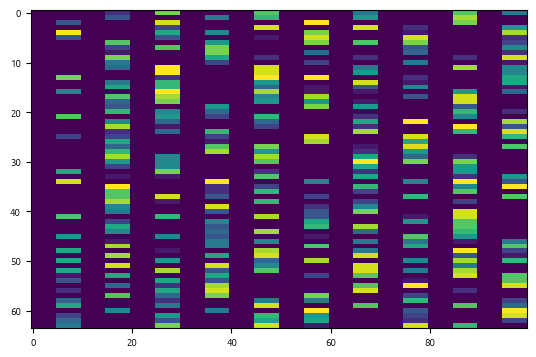

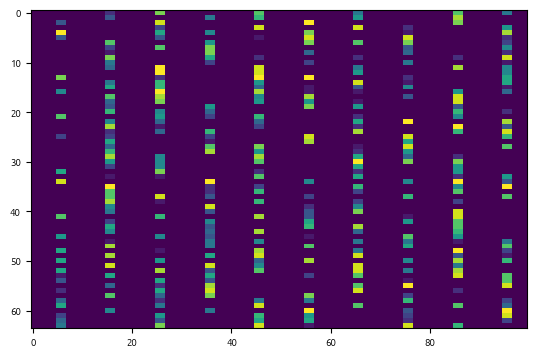

In [7]:

inputs, labels = dataset()
labels = np.transpose(labels, (1, 0))
plt.figure()
plt.imshow(labels)
plt.show()
labels_compressed = compress_labels(labels)
plt.figure()
plt.imshow(labels_compressed)
plt.show()

In [7]:
#save the model
save = True

if save:

    name = "model_rim_12_mono"
    
    torch.save(model.state_dict(), 'saved_models/'+name+'.pth')

    # save the parameters
    parameters = {'input_size': input_size,
                'hidden_size': hidden_size,
                'output_size': output_size,
                'num_mechanisms': num_mechanisms,
                'key_size': key_size,
                'rank': rank,
                'num_heads': num_heads}
    # yaml
    import yaml
    with open('saved_models/'+name+'.yaml', 'w') as file:
        documents = yaml.dump(parameters, file)

In [ ]:
tree

load = True 
if load :

    name = "model_rim_5"
    
    model = RIMNetwork_specialized_multHead(input_size, hidden_size, output_size, num_mechanisms=num_mechanisms,
                    key_size=key_size, rank=rank, num_heads=num_heads,task_size=len(envs_simple)).to(device)
    model.load_state_dict(torch.load('saved_models/'+name+'.pth'))  

NameError: name 'tree' is not defined

### Assess on individual task

In [8]:
envs_simple = [go(), rtgo(), dlygo(), anti(), rtanti(), dlyanti(),
                dm1(), dm2(), ctxdm1(), ctxdm2(), multidm(),
                dlydm1(), dlydm2(),ctxdlydm1(), ctxdlydm2(), multidlydm(),
                dms(), dnms(), dmc(), dnmc()]


envs_name = ['go', 'rtgo', 'dlygo', 'anti', 'rtanti', 'dlyanti',
                'dm1', 'dm2', 'ctxdm1', 'ctxdm2', 'multidm', 
                'dlydm1', 'dlydm2','ctxdlydm1', 'ctxdlydm2', 'multidlydm', 
                'dms', 'dnms', 'dmc', 'dnmc']

envs_simple = [go(), rtgo(), dlygo(), anti(), rtanti(), dlyanti()]
envs_name = ['go', 'rtgo', 'dlygo', 'anti', 'rtanti', 'dlyanti']

batch_size = 1
seq_len = 1000

task_units_variance = []
task_accuracy = []

from tqdm import tqdm

for i,env in tqdm(enumerate(envs_simple)) :

    # iterable dataset from which it is possible to draw samples
    dataset = Dataset(env, batch_size=batch_size, seq_len=seq_len)
    ob_size = env.observation_space.shape[0]
    act_size = env.action_space.n

    # we test for one trajectory
    inputs, labels = dataset()
    # we need to add 20 dimensions to the input, corresponding to the task identity

    inputs = np.transpose(inputs, (1, 0, 2))
    labels = np.transpose(labels, (1, 0))
    
    # we need to add 20 dimensions to the input, corresponding to the task identity
    nb_task = len(envs_simple)
    task_identity = np.zeros((inputs.shape[0],inputs.shape[1],nb_task))
    task_identity[:,:,i] = 1
    inputs = np.concatenate((inputs,task_identity),axis=2)
    
    outputs_total,hidden_states,attn_in, attn_com,_ = model(torch.tensor(inputs,dtype=torch.float).to(device))
    
    targets = np.eye(act_size)[labels]

    outputs = outputs_total.detach().cpu().numpy()
    

    '''

    attn_in = torch.stack(attn_in).detach().cpu().numpy()
    attn_com = torch.stack(attn_com).detach().cpu().numpy()
    attn_in = attn_in.reshape(seq_len,-1)
    attn_com = attn_com.reshape(seq_len,-1)
    
    print(outputs.shape, attn_in.shape, attn_com.shape)
    plt.figure()
    plt.subplot(411)
    plt.imshow(inputs[:,:,:].T)
    plt.subplot(412)
    plt.imshow((outputs[:,:,:].T))
    plt.subplot(413)
    plt.imshow(targets[:,:,:].T)
    plt.subplot(414)
    plt.plot(attn_com[:,:])
    plt.show()
    '''

    # we can also now compute the accuracy on each task !
    labels = compress_labels(labels)
    mask = labels > 0
    output_max = np.argmax(outputs_total.detach().cpu().numpy(),axis=2)
    accuracy = np.sum((output_max==labels)*mask)/ np.sum(mask)
    task_accuracy.append(accuracy)

    hidden_states = np.squeeze(torch.stack(hidden_states).detach().cpu().numpy(),axis=1)
    hidden_states = hidden_states.reshape(seq_len,-1)

    units_variance = np.var(hidden_states,axis=0)
    task_units_variance.append(units_variance)
    
task_units_variance = np.array(task_units_variance) + 1e-10
# we normalize the variance of each unit
task_units_variance = task_units_variance/np.max(task_units_variance,axis=0)

6it [00:08,  1.45s/it]


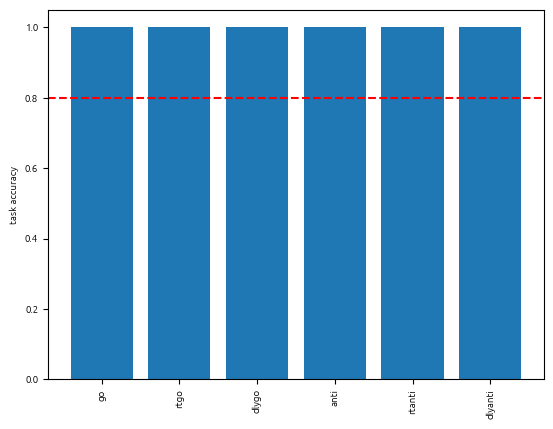

In [9]:
### plot task accuracy
plt.figure()
plt.bar(envs_name,task_accuracy)
plt.xticks(rotation=90)
plt.ylabel('task accuracy')
plt.axhline(0.8,color='r',linestyle='--')
plt.show()

In [13]:
# we use kmean to compute cluster of RNN units
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=0).fit(task_units_variance.T)
cluster_labels = kmeans.labels_
# permute units activity array to have them grouped by cluster
task_units_variance = task_units_variance[:,np.argsort(cluster_labels)]

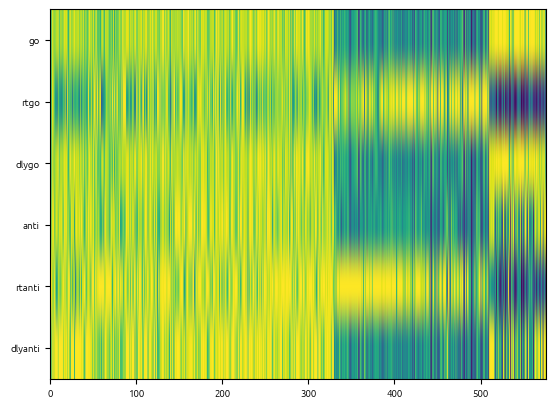

In [14]:
plt.figure()
plt.imshow(task_units_variance,aspect='auto')
plt.yticks(np.arange(len(envs_name)),envs_name)
plt.show()

In [ ]:
from sklearn.decomposition import PCA
from matplotlib.collections import LineCollection
from matplotlib.colors import LinearSegmentedColormap

envs_simple = [go(), rtgo(), dlygo(), anti(), rtanti(), dlyanti(),
                dm1(), dm2(), ctxdm1(), ctxdm2(), multidm(), dlydm1(), dlydm2(),
                ctxdlydm1(), ctxdlydm2(), multidlydm(), dms(), dnms(), dmc(), dnmc()]

envs_name = ['go', 'rtgo', 'dlygo', 'anti', 'rtanti', 'dlyanti',
                'dm1', 'dm2', 'ctxdm1', 'ctxdm2', 'multidm', 'dlydm1', 'dlydm2',
                'ctxdlydm1', 'ctxdlydm2', 'multidlydm', 'dms', 'dnms', 'dmc', 'dnmc']


envs_simple = [go(), rtgo(), dlygo(), anti(), rtanti(), dlyanti()]
envs_name = ['go', 'rtgo', 'dlygo', 'anti', 'rtanti', 'dlyanti']

batch_size = 1
seq_len = 1000

task_units_variance = []
task_accuracy = []

for i,env in enumerate(envs_simple) :
        



        # iterable dataset from which it is possible to draw samples
        dataset = Dataset(env, batch_size=batch_size, seq_len=seq_len)
        ob_size = env.observation_space.shape[0]
        act_size = env.action_space.n

        # we test for one trajectory
        inputs, labels = dataset()
        inputs = np.transpose(inputs, (1, 0, 2))
        labels = np.transpose(labels, (1, 0))
        targets = np.eye(act_size)[labels]
        
        # we need to add 20 dimensions to the input, corresponding to the task identity
        task_identity = np.zeros((inputs.shape[0],inputs.shape[1],len(envs_simple)))
        task_identity[:,:,i] = 1
        inputs = np.concatenate((inputs,task_identity),axis=2)
        
        outputs_total,hidden_states,attn_in, attn_com,_ = model(torch.tensor(inputs,dtype=torch.float).to(device))


        targets = np.eye(act_size)[labels]

        outputs = outputs_total.detach().cpu().numpy()
        attn_in = torch.stack(attn_in).detach().cpu().numpy()
        attn_com = attn_com.detach().cpu().numpy() # torch.stack(attn_com)
        attn_in = attn_in.reshape(seq_len,-1)
        attn_com = attn_com.reshape(seq_len,-1)

        f = plt.figure()
        plt.subplot(411)
        plt.imshow(inputs[:,:,:].T,aspect='auto')
        plt.subplot(412)
        plt.imshow((outputs[:,:,:].T),aspect='auto')
        plt.subplot(413)
        plt.imshow(targets[:,:,:].T,aspect='auto')
        plt.subplot(414)
        # plt.imshow(attn_com[:,:].T,aspect='auto')
        # plt.plot(attn_com[:,:])
        attn_com_len = attn_com.shape[1]
        plt.plot(np.mean(attn_com[:,:attn_com_len//3],axis=1))
        plt.plot(np.mean(attn_com[:,attn_com_len//3:2*attn_com_len//3],axis=1))
        plt.plot(np.mean(attn_com[:,2*attn_com_len//3:],axis=1))
        plt.title(envs_name[i])
        f.tight_layout()
        f.show()

        # we want to sequence the sequenc into trials by getting index of when the task changes
        task_changes = np.where(np.diff((inputs[0,:,0] > 0)*1) > 0)[0]
        # we add 0 and the last index to the task changes
        task_changes = np.concatenate(([0],task_changes,[len(inputs[0])]))
        print(task_changes)
        # Create color gradient for each trial
        trial_colors = []
        for i_trial in range(len(task_changes)-1):
            trial_length = task_changes[i_trial+1] - task_changes[i_trial]
            gradient = np.linspace(0, 1, trial_length)
            trial_colors.extend(gradient)

        # Choose a colormap (e.g., 'viridis', 'plasma', 'magma', 'inferno')
        cmap = plt.cm.viridis

        # Convert progression values to RGB colors
        colors = cmap(trial_colors)  # Returns RGBA values for each point


        hidden_states = np.squeeze(torch.stack(hidden_states).detach().cpu().numpy(),axis=1)
        # hidden_states = hidden_states.reshape(seq_len,-1)
        
        # for every module we would like to see the pca space of the hidden states
        f,axs = plt.subplots(3,3,figsize=(10,5))
        for i_mech in range(hidden_states.shape[1]) :
            hidden_states_mech = hidden_states[:,i_mech,:]
            hidden_states_mech = hidden_states_mech.T
            pca = PCA(n_components=2)
            pca.fit(hidden_states_mech)
            ax = axs[i_mech//3,i_mech%3]
            # ax.scatter(pca.components_[0,:],pca.components_[1,:],c=colors)
            points = np.column_stack((pca.components_[0,:], pca.components_[1,:]))
            segments = np.array([points[i:i+2] for i in range(len(points)-1)])
            lc = LineCollection(segments, cmap='viridis', array=trial_colors[:-1])
            ax.add_collection(lc)
            ax.autoscale()
        f.suptitle(envs_name[i])
        plt.show()

In [ ]:
#### THIS IS A BETTER VERSION OF THE TRAINING LOOP WITH INTERESTING IDEAS FOR THE LOSS BUT TO BE DISMISSED FOR NOW ####
losss = []
loss_moving_average = 0
# Training Loop
num_training_steps = 5000
for i_step in tqdm(range(num_training_steps)):
        
        # To draw samples, use neurogym's dataset class:
        inputs, labels = dataset()

        fixation_mask = inputs[:,:,0] > 0  # Shape: [100, 64]
        fixation_mask = torch.tensor(fixation_mask).to(device)
        active_mask = ~fixation_mask.reshape(-1)

        inputs = np.transpose(inputs, (1, 0, 2))
        labels = np.transpose(labels, (1, 0))

        labels = compress_labels(labels)

        outputs_total,_,_,_,attention_weights = model(torch.tensor(inputs,dtype=torch.float).to(device))
        
        output_masked = outputs_total.reshape(-1,act_size)[active_mask]
        labels_masked = torch.tensor(labels).to(device).reshape(-1)[active_mask]

        # Calculate class weights including all possible classes / we remove ignore_index=0 when a task has a non response possibility
        '''num_classes = act_size  # 17
        label_counts = torch.bincount(torch.tensor(labels_masked).flatten(), minlength=num_classes)
        class_weights = 1.0 / (label_counts.float() + 1e-6)  # Add small epsilon to avoid division by zero
        class_weights = class_weights / class_weights.sum()  # Normalize
        class_weights = class_weights.to(device)
        print('class_weights',class_weights)'''

        criterion = nn.CrossEntropyLoss(ignore_index=0) # weight=class_weights
        masked_loss = criterion(output_masked,labels_masked)

        # compute fixation penalty loss
        outputs_reshaped = outputs_total.permute(1, 0, 2) 
        fixation_penalty = outputs_reshaped[fixation_mask].pow(2).mean()

        # compute penality for the size of attention weights
        n_att_weights = attention_weights.numel()
        attention_loss = torch.sum(torch.abs(attention_weights)) / n_att_weights

        total_loss = masked_loss + 0.01*fixation_penalty + 0.1*attention_loss

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        # loss moving average
        loss_moving_average = 0.99 * loss_moving_average + 0.01 * total_loss.item()
        losss.append(loss_moving_average)

        mask = labels > 0
        output_max = np.argmax(outputs_total.detach().cpu().numpy(),axis=2)
        accuracy = np.sum((output_max==labels)*mask)/ np.sum(mask)

        writer.add_scalar("Loss/train", total_loss.item(), i_step) 
        writer.add_scalar("Accuracy/train", accuracy, i_step)
        writer.add_scalar("loss_attention", attention_loss.item(), i_step)

        if i_step % 100 == 0:
            print(f'Step [{i_step}/{num_training_steps}], Loss: {total_loss.item()}')
            print('accuracy',accuracy)
        
writer.flush()